In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.constants import c
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
pwr = np.fromfile('meridian_pwr.f32', dtype = 'float32')
pwr /= np.median(pwr)
T = 100e-6
t = np.arange(pwr.size) * T

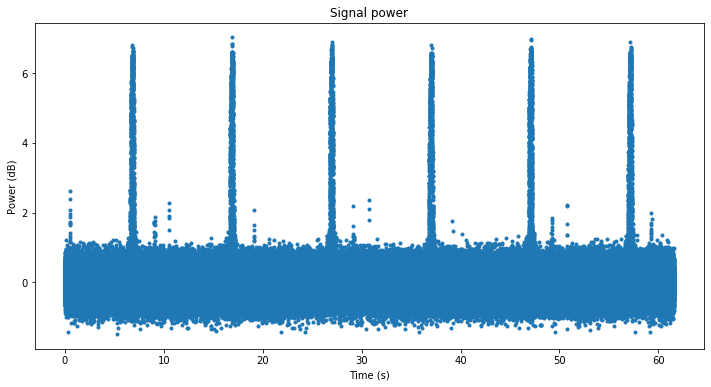

In [3]:
plt.plot(t, 10 * np.log10(pwr), '.')
plt.title('Signal power')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)');

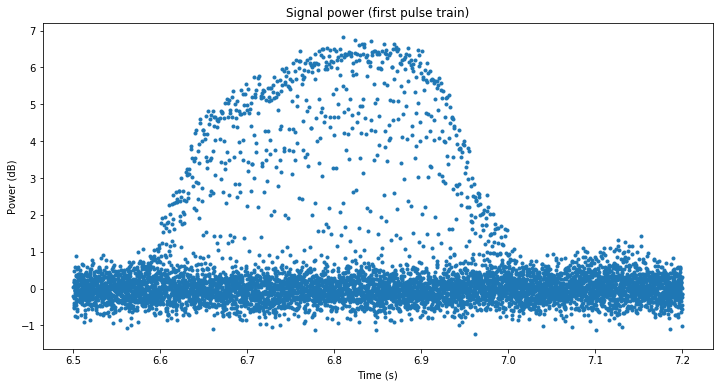

In [4]:
sel = slice(65000,72000)
plt.plot(t[sel], 10 * np.log10(pwr[sel]), '.')
plt.title('Signal power (first pulse train)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)');

In [5]:
fs = 2e6
start = 6.5
end = 7.1
duration = end - start
x = np.fromfile('/home/daniel/Descargas/gqrx_20210117_223857_994299999_2000000_fc.raw',
               dtype = 'complex64', offset = 8 * int(fs * start),
               count = int(fs * duration))

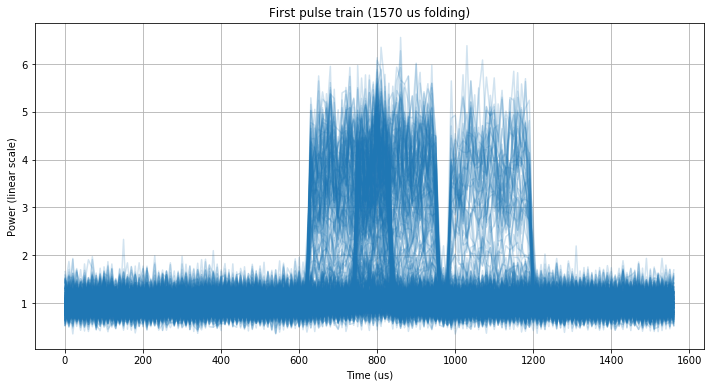

In [6]:
avg = 20
fold = 3140//avg
xp = x[80*avg:] # drop some sample to center the graph
xp = np.average(np.abs(xp[:xp.size//avg*avg].reshape((-1,avg)))**2, axis = 1)
xp /= np.median(xp)
xp_fold = xp[:xp.size//fold*fold].reshape((-1,fold))
tau = np.arange(xp_fold.shape[1])/(fs/avg)
plt.plot(tau * 1e6, xp_fold.T, '-', color = 'C0', alpha = 0.2)
plt.xlabel('Time (us)')
plt.ylabel('Power (linear scale)')
plt.grid()
plt.title('First pulse train (1570 us folding)');

In [7]:
fold_t = fold * avg / fs
fold_t

0.00157

In [8]:
fold_f = 1/fold_t
fold_f

636.9426751592357

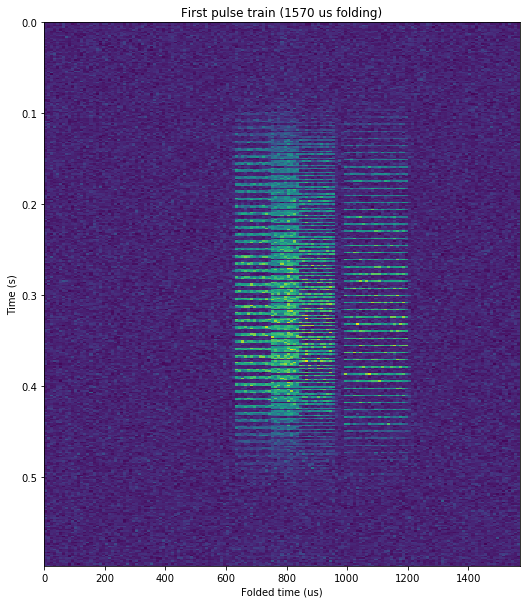

In [9]:
plt.figure(figsize = (10,10))
plt.imshow(xp_fold, aspect = 3e3, extent = (0, 1570, xp_fold.shape[0]*fold_t, 0))
plt.title('First pulse train (1570 us folding)')
plt.ylabel('Time (s)')
plt.xlabel('Folded time (us)');

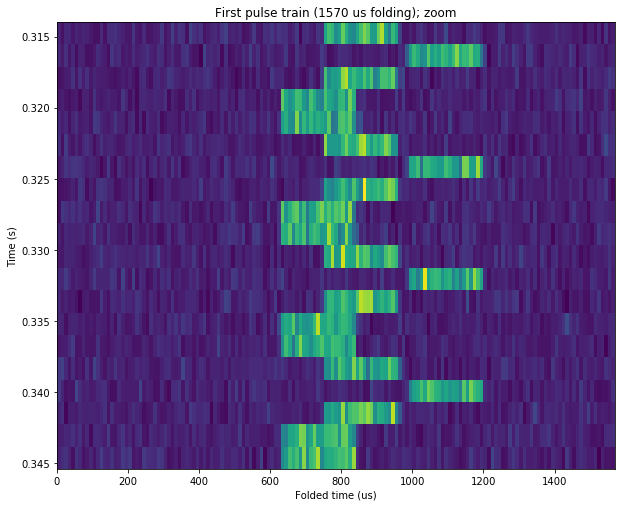

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(xp_fold[200:220], aspect = 4e4, extent = (0, 1570, 220*fold_t, 200*fold_t))
plt.title('First pulse train (1570 us folding); zoom')
plt.ylabel('Time (s)')
plt.xlabel('Folded time (us)');

In [11]:
y = x[2100*256:2200*256]

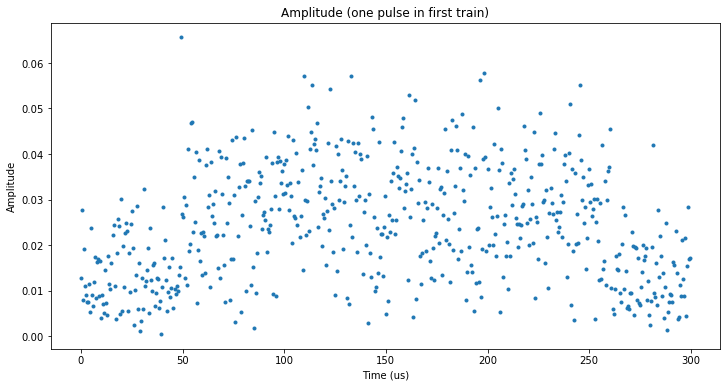

In [12]:
sel = slice(14900,15500)
plt.plot(np.arange(y[sel].size)/fs*1e6, np.abs(y[sel]), '.')
plt.title('Amplitude (one pulse in first train)')
plt.ylabel('Amplitude')
plt.xlabel('Time (us)');

-91666.66666666667

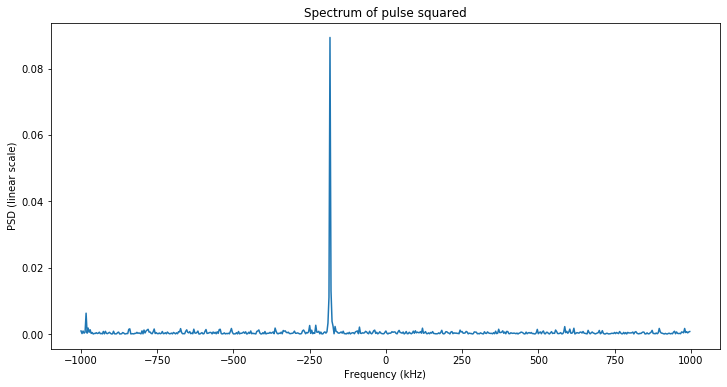

In [13]:
z = y[sel]
freqs = np.fft.fftfreq(z.size, 1/fs)
fzsq = np.abs(np.fft.fft(z**2))**2
plt.plot(np.fft.fftshift(freqs)*1e-3, np.fft.fftshift(fzsq))
plt.title('Spectrum of pulse squared')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (linear scale)')
f_offset = freqs[np.argmax(fzsq)]/2
f_offset

In [14]:
z0 = z * np.exp(-1j*2*np.pi*f_offset/fs*np.arange(z.size))

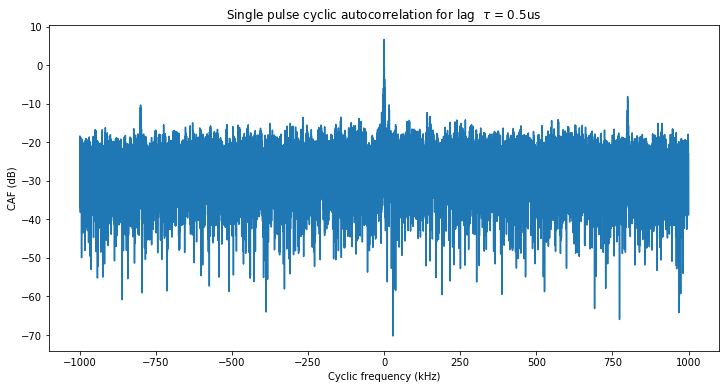

In [15]:
g = 20*np.log10(np.abs(np.fft.fft(y[1:] * np.conjugate(y[:-1]))))
freqs = np.fft.fftfreq(g.size, 1/fs)
plt.plot(np.fft.fftshift(freqs)*1e-3, np.fft.fftshift(g))
plt.title('Single pulse cyclic autocorrelation for lag  $\\tau$ = 0.5us')
plt.xlabel('Cyclic frequency (kHz)')
plt.ylabel('CAF (dB)');

In [16]:
np.fft.fftfreq(g.size, 1/fs)[np.argmax(g[5000:20000])+5000]

800031.2512207509

In [17]:
baudrate = 800e3

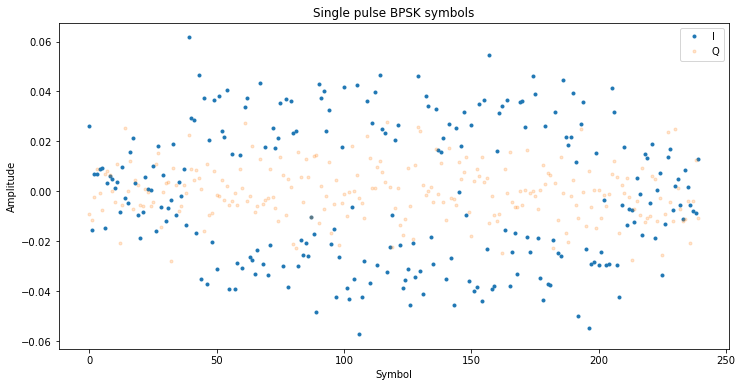

In [18]:
sps = fs/baudrate
tau = np.arange(0.7, z0.size, sps)
syms = z0[np.int32(np.round(tau))]
syms *= np.exp(1j*np.deg2rad(62))
plt.plot(syms.real, '.')
plt.plot(syms.imag, '.', alpha = 0.2)
plt.legend(['I', 'Q'])
plt.title('Single pulse BPSK symbols')
plt.xlabel('Symbol')
plt.ylabel('Amplitude');

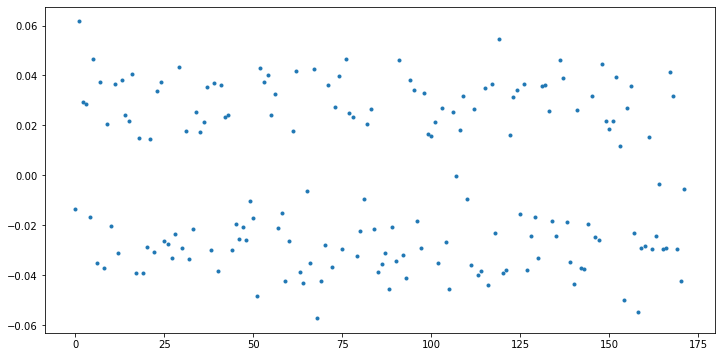

In [19]:
symsel = syms[38:210]
plt.plot(symsel.real, '.')

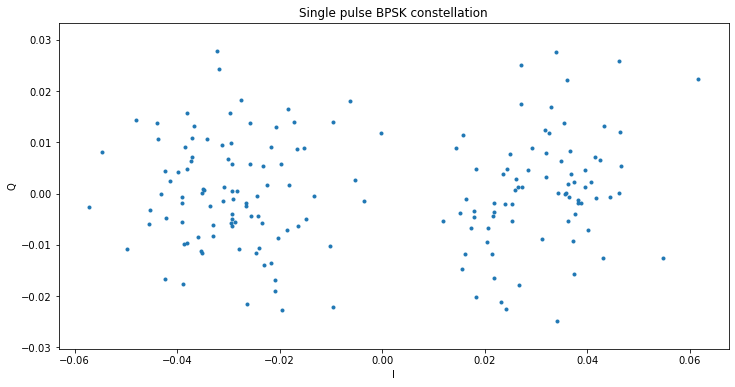

In [20]:
plt.plot(symsel.real, symsel.imag, '.')
plt.axis('equal')
plt.title('Single pulse BPSK constellation')
plt.xlabel('I')
plt.ylabel('Q');

-91473.40956117463

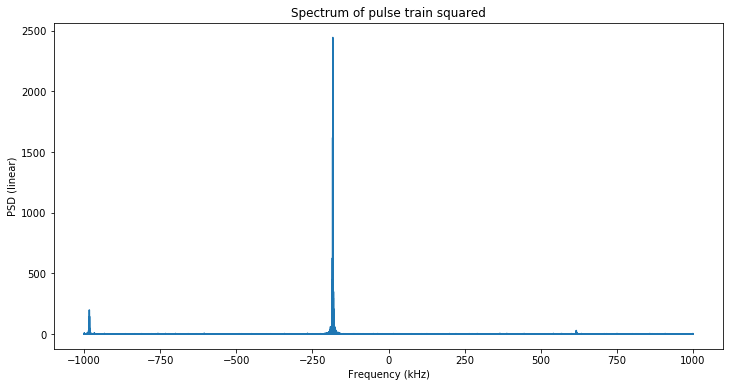

In [21]:
fx = np.abs(np.fft.fft(x**2))**2
freqs = np.fft.fftfreq(fx.size, 1/fs)
plt.plot(np.fft.fftshift(freqs)*1e-3, np.fft.fftshift(fx))
plt.title('Spectrum of pulse train squared')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (linear)')
f_offset = freqs[np.argmax(fx)]/2
f_offset

In [22]:
x0 = x * np.exp(-1j*2*np.pi*f_offset/fs*np.arange(x.size)) * np.exp(1j * np.deg2rad(35))
x0_fold = x0[80*avg:] # drop some sample to center the pulses
n = int(fold_t * fs)
x0_fold = x0_fold[:x0_fold.size//n*n].reshape((-1,n))

In [23]:
template = x0_fold[100]
x0_fold_correct = x0_fold.copy()
for j in range(x0_fold.shape[0]):
    candidate = x0_fold[j]
    corr = np.correlate(candidate, template, mode = 'full')
    lag = np.argmax(np.abs(corr)) - template.size + 1
    x0_fold_correct[j] = np.roll(candidate, -lag) * np.exp(-1j*np.angle(corr[np.argmax(np.abs(corr))]))

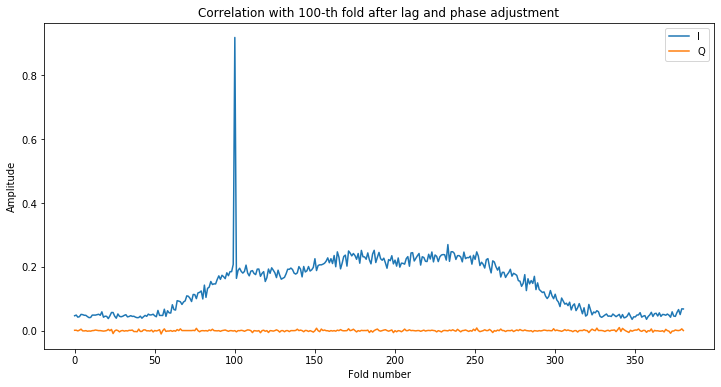

In [24]:
cross = np.sum(x0_fold_correct * np.conjugate(template), axis = 1)
plt.plot(cross.real)
plt.plot(cross.imag)
plt.title('Correlation with 100-th fold after lag and phase adjustment')
plt.legend(['I','Q'])
plt.xlabel('Fold number')
plt.ylabel('Amplitude');

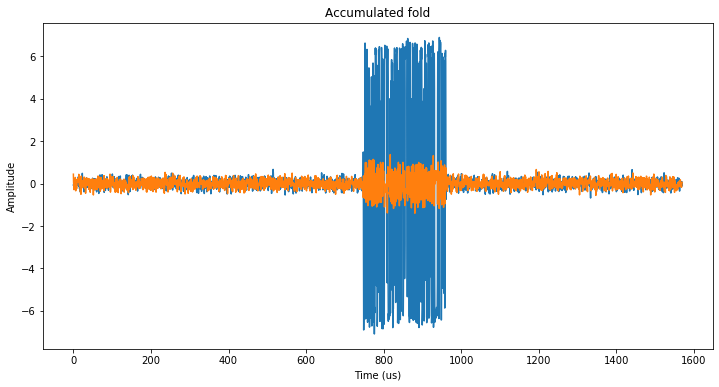

In [25]:
acc = np.sum(x0_fold_correct[50:320], axis = 0)
s = np.arange(acc.size) / fs * 1e6
plt.plot(s, acc.real)
plt.plot(s, acc.imag)
plt.title('Accumulated fold')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude');

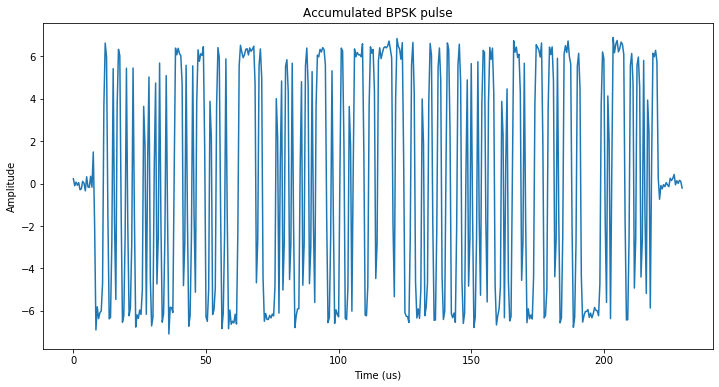

In [26]:
pulse = acc[1480:1940].real
s = np.arange(pulse.size) / fs * 1e6
plt.plot(s, pulse)
plt.title('Accumulated BPSK pulse')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude');

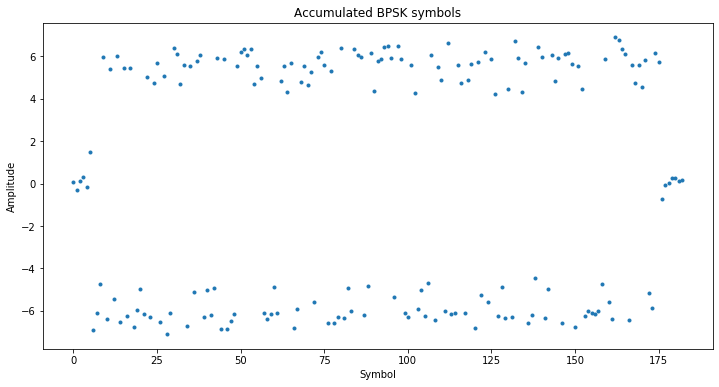

In [27]:
sps = fs/baudrate
tau = np.arange(2.1, pulse.size-1, sps)
pulse_syms = pulse[np.int32(np.round(tau))]
plt.plot(pulse_syms, '.')
plt.title('Accumulated BPSK symbols')
plt.xlabel('Symbol')
plt.ylabel('Amplitude');

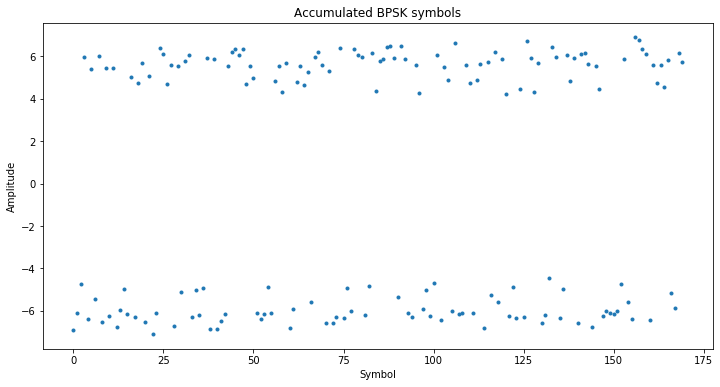

In [28]:
pulse_syms_crop = pulse_syms[6:-7]
plt.plot(pulse_syms_crop, '.')
plt.title('Accumulated BPSK symbols')
plt.xlabel('Symbol')
plt.ylabel('Amplitude');

In [29]:
sequence = np.sign(pulse_syms_crop)
sequence.size

170

In [30]:
sequence.size/baudrate * 1e6

212.5

This checks that the symbols in the single pulse coincide with the symbols in the accumulated pulse, showing that all pulses have the same symbol sequence.

In [31]:
np.max(np.abs(np.correlate(np.sign(symsel.real), sequence)))

170.0

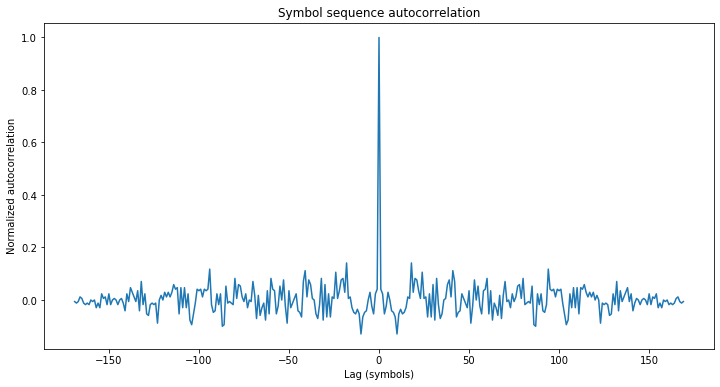

In [32]:
plt.plot(np.arange(-sequence.size+1, sequence.size), np.correlate(sequence, sequence, mode = 'full')/sequence.size)
plt.title('Symbol sequence autocorrelation')
plt.xlabel('Lag (symbols)')
plt.ylabel('Normalized autocorrelation');

In [33]:
seq = ''.join([str(a) for a in ((sequence+1)//2).astype('int')])
seq

'00010101010100001011010011110101100001010001111111100000111100111101110100100011100111111101100110000101101001101101010110001011110001100111011101100000010011110111110011'

This shows how many different subsequences of 15 and 16 bits are inside the full sequence. The fact that there are some repeated subsequences still for size 15 shows that this sequence is not a subsequence of an M-sequence.

In [34]:
for l in [15, 16]:
    states = [seq[j:j+l] for j in range(0, len(seq)-l+1)]
    print(l, len(states), len(set(states)))

15 156 155
16 155 155


In [35]:
sparse = np.fromfile('meridian_corr_sparse.c64', dtype = 'complex64')
sparse_pos = np.fromfile('meridian_corr_sparse_pos.i32', dtype = 'uint32')
sparse_t = sparse_pos / fs

In [36]:
def peak_finder(t, x, threshold = 1e-3):
    t0, x0 = t[0], x[0]
    for tt, xx in zip(t[1:], x[1:]):
        if tt - t0 > threshold:
            yield t0, x0
            t0, x0 = tt, xx
        elif np.abs(xx) >= np.abs(x0):
            t0, x0 = tt, xx
    yield t0, x0

In [37]:
pf = list(peak_finder(sparse_t, sparse))
peak_t = np.array([p[0] for p in pf])
peak = np.array([p[1] for p in pf])
peak /= np.max(np.abs(peak))

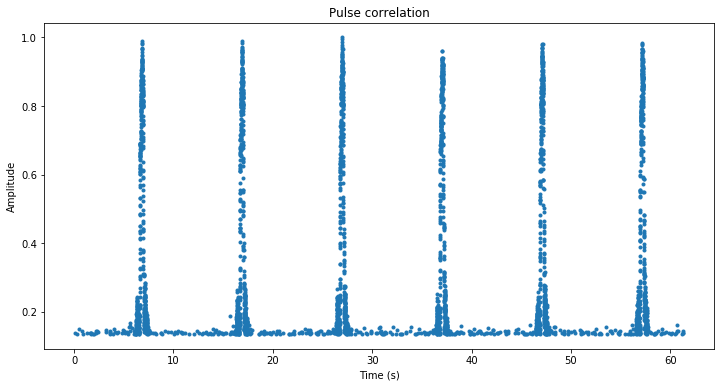

In [38]:
plt.plot(peak_t, np.abs(peak), '.')
plt.title('Pulse correlation')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)');

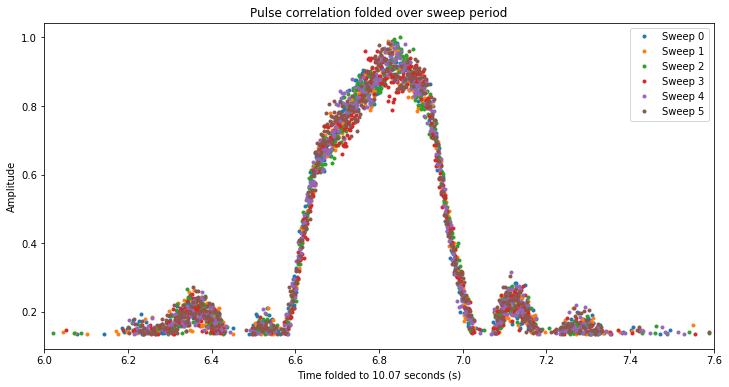

In [39]:
fold_sweep = 10.07
Nsweeps = int(peak_t[-1]/fold_sweep)
for j in range(Nsweeps):
    sel = (peak_t >= j*fold_sweep) & (peak_t < (j+1)*fold_sweep)
    plt.plot(peak_t[sel] % fold_sweep, np.abs(peak[sel]), '.')
plt.xlim(6.0,7.60)
plt.legend([f'Sweep {j}' for j in range(Nsweeps)])
plt.title('Pulse correlation folded over sweep period')
plt.ylabel('Amplitude')
plt.xlabel(f'Time folded to {fold_sweep} seconds (s)');

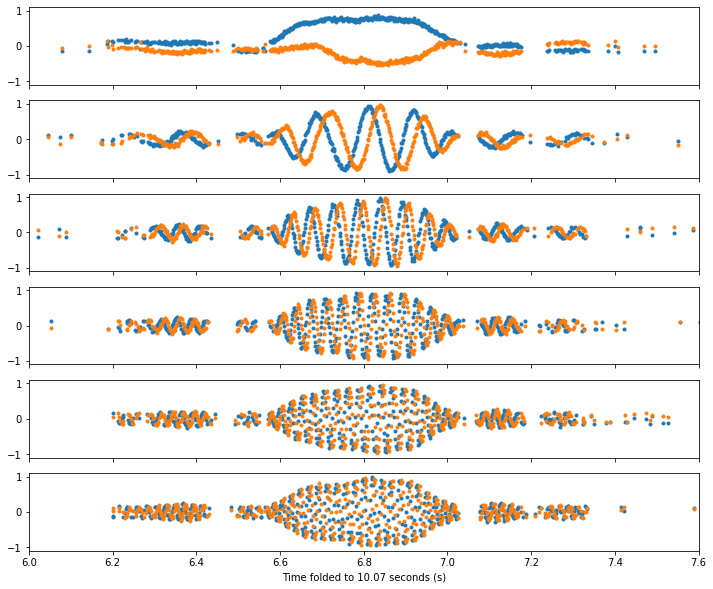

In [40]:
fig, axs = plt.subplots(Nsweeps, 1, sharex = True, figsize = (12,10))
for j in range(Nsweeps):
    sel = (peak_t >= j*fold_sweep) & (peak_t < (j+1)*fold_sweep)
    axs[j].plot(peak_t[sel] % fold_sweep, peak[sel].real, '.')
    axs[j].plot(peak_t[sel] % fold_sweep, peak[sel].imag, '.')
    axs[j].set_xlim(6.0,7.60)
    axs[j].set_ylim(-1.1, 1.1)
axs[-1].set_xlabel(f'Time folded to {fold_sweep} seconds (s)');

Text(0.5, 0, 'Time (s)')

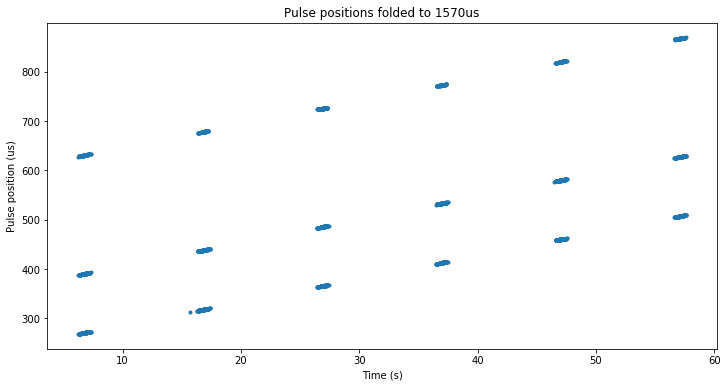

In [41]:
cutoff = np.abs(peak) > 0.17
plt.plot(peak_t[cutoff], (peak_t[cutoff] % fold_t)*1e6, '.')
plt.title('Pulse positions folded to 1570us')
plt.ylabel('Pulse position (us)')
plt.xlabel('Time (s)')

Text(0, 0.5, 'Inter-pulse period (us)')

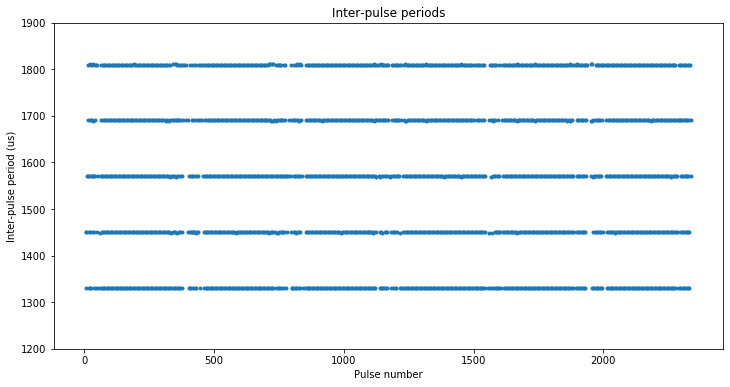

In [42]:
ipp = np.diff(peak_t[cutoff]) # inter-pulse period
plt.plot(ipp * 1e6, '.')
plt.ylim((1200, 1900))
plt.title('Inter-pulse periods')
plt.xlabel('Pulse number')
plt.ylabel('Inter-pulse period (us)')

In [43]:
for cluster in [1350, 1450, 1600, 1700, 1800]:
    sel = np.abs(ipp - cluster*1e-6) < 50e-6
    print(np.average(ipp[sel]*1e6))

1329.9988151658583
1449.999999999995
1570.0209790210515
1690.0023419203862
1810.0140186916115


In [44]:
ipps = np.array([1330, 1450, 1570, 1690, 1810])*1e-6
ipps*1e6 - 1570

array([-240., -120.,    0.,  120.,  240.])

In [45]:
170/baudrate*1e6

212.5

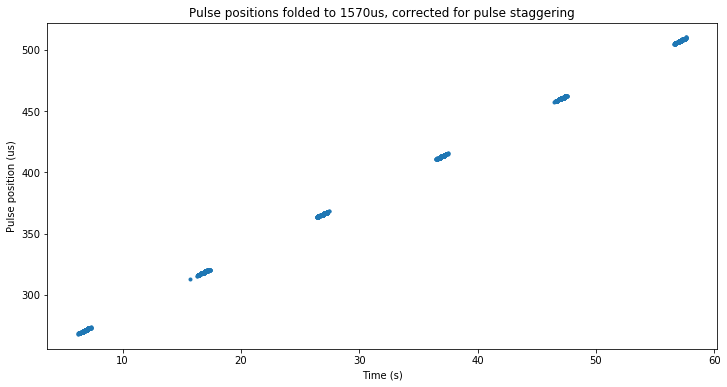

In [46]:
peak_t_5 = peak_t % (5*fold_t)
peak_t_fold = peak_t % fold_t
stagger = [0, 120e-6, 360e-6, 120e-6, 0]
for j in range(5):
    div = (peak_t_5 + 0)/fold_t
    peak_t_fold[(div >= j) & (div < (j+1))] -= stagger[j]
plt.plot(peak_t[cutoff], (peak_t_fold[cutoff])*1e6, '.')
plt.title('Pulse positions folded to 1570us, corrected for pulse staggering')
plt.ylabel('Pulse position (us)')
plt.xlabel('Time (s)');

In [47]:
p = np.polyfit(peak_t[cutoff], peak_t_fold[cutoff], 1)
p[0]*c

1409.2220586887836